In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('PADERBON_new.csv')

In [5]:
avg_motor_speed = df['stator_winding'].mean()
print(f"Average stator_winding  temp: {avg_motor_speed}")

Average stator_winding  temp: 66.34274539496714


In [6]:
features = ['timestamp','u_q', 'coolant',  'u_d', 'motor_speed', 'i_d', 'i_q', 'pm', 'torque']
target = 'stator_winding'

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [8]:
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

In [9]:
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [11]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.0102 - val_loss: 0.0062
Epoch 2/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 3/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 4/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 5/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 6/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 7/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 8/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 9/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 10/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 11/50
33271/33271 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 0.0052 - val_loss: 0.00

In [14]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

8318/8318 ━━━━━━━━━━━━━━━━━━━━ 5s 584us/step - loss: 0.0029
Test Loss: 0.0028881244361400604


In [15]:
model.save('statorwinding_custom_model.h5')
model.save_weights('statorwinding_custom_weights.weights.h5')

In [16]:
y_pred = model.predict(X_test)

8318/8318 ━━━━━━━━━━━━━━━━━━━━ 6s 671us/step


In [17]:
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, 0], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, 0], y_pred.reshape(-1, 1)), axis=1))[:, -1]

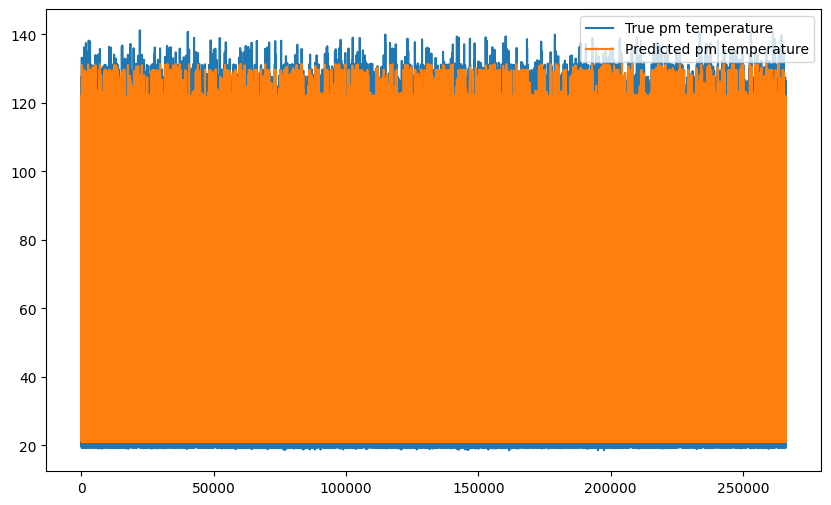

In [18]:
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True pm temperature')
plt.plot(y_pred_rescaled, label='Predicted pm temperature')
plt.legend()
plt.show()

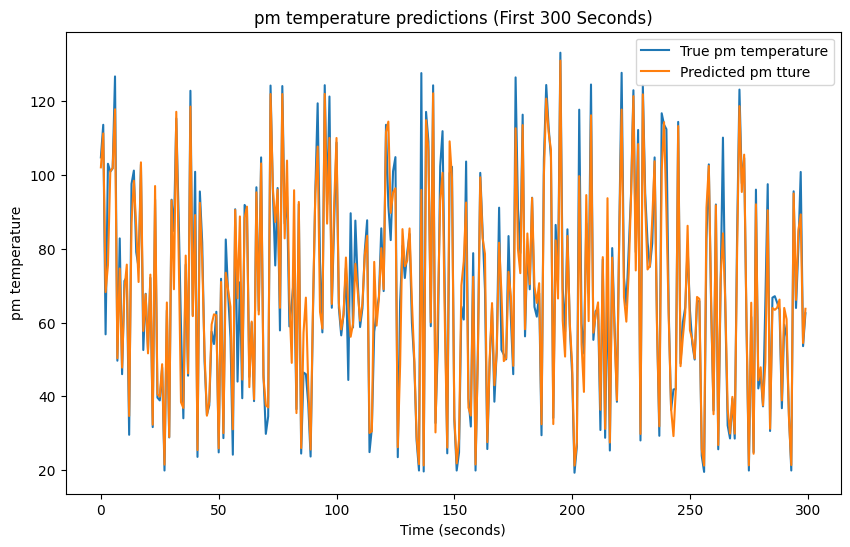

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:300], label='True pm temperature')
plt.plot(y_pred_rescaled[:300], label='Predicted pm tture')
plt.legend()
plt.title("pm temperature predictions (First 300 Seconds)")
plt.xlabel("Time (seconds)")
plt.ylabel("pm temperature")
plt.show()


In [20]:
def predict_custom_input(custom_input):
    custom_input_scaled = scaler.transform([custom_input])
    custom_input_reshaped = custom_input_scaled[:, :-1].reshape(1, 1, len(features))
    prediction = model.predict(custom_input_reshaped)
    prediction_rescaled = scaler.inverse_transform(np.concatenate((custom_input_reshaped[:, 0], prediction), axis=1))[:, -1]
    return prediction_rescaled

custom_input = [0.5,-0.4, 18.08, 19.08, -0.35, 0, 0.0044, 0.0003, 24.554, 0.187]  # Modify as per your need
output = predict_custom_input(custom_input)
print(f"Predicted motor speed for custom input: {output}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted motor speed for custom input: [22.90654371]


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
